Na czym się skupiamy?
Przewidywaniu czy pada deszcz kolejnego dnia.

Punkty do zrobienia:
1. Tabela NaN, statystyki NaN, odrzucenie kolumn NaN, mapa NaN
2. Sprawdzić lokalizacje, zrobić grupowanie na dane obszary, może zrzutować na mapę.
3. Różne wykresy zależności, boxploty przy ciągłych, (np. jak deszcz był kolejnego dnia to wilgotność taka a jak ni ebyło to obok drugi wykres).
4. Mapa porównań.
6. Heatmapa korelacji.
7. Przy każdym kierunku wiatru proporje tych dni w których kolejnego padało do tych gdy nie padało
8. Współczynniki korelacji między tymi samymi danymi o różnych godzinach. Jak będzie duża korelacja to uśredniami albo wybieramy jedną.
9. Może coś o powiązaniu ze zjawiskiem ENSO?
10. Może rozbić wiatr na kierunki w 4 kolumnach.
11. Wyciągnąć miesiąc z daty i to dać jako nowy parametr, zamiast daty
12. Dodać kolumnę z parametrem zjawiska ENSO z zewnętrznej ramki.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv('weatherAUS.csv')

# Data Analysis

In [41]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [21]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


## Missing Values

In [39]:
#Function for missing 
def missing(dataframe):
    total = dataframe.isnull().sum()
    percent = round(dataframe.isnull().sum()/len(df)*100, 2)
    missing = pd.concat([percent,total], axis=1, keys=['Percent','Total']).sort_values(by = ['Percent'], ascending = False).T
    return missing

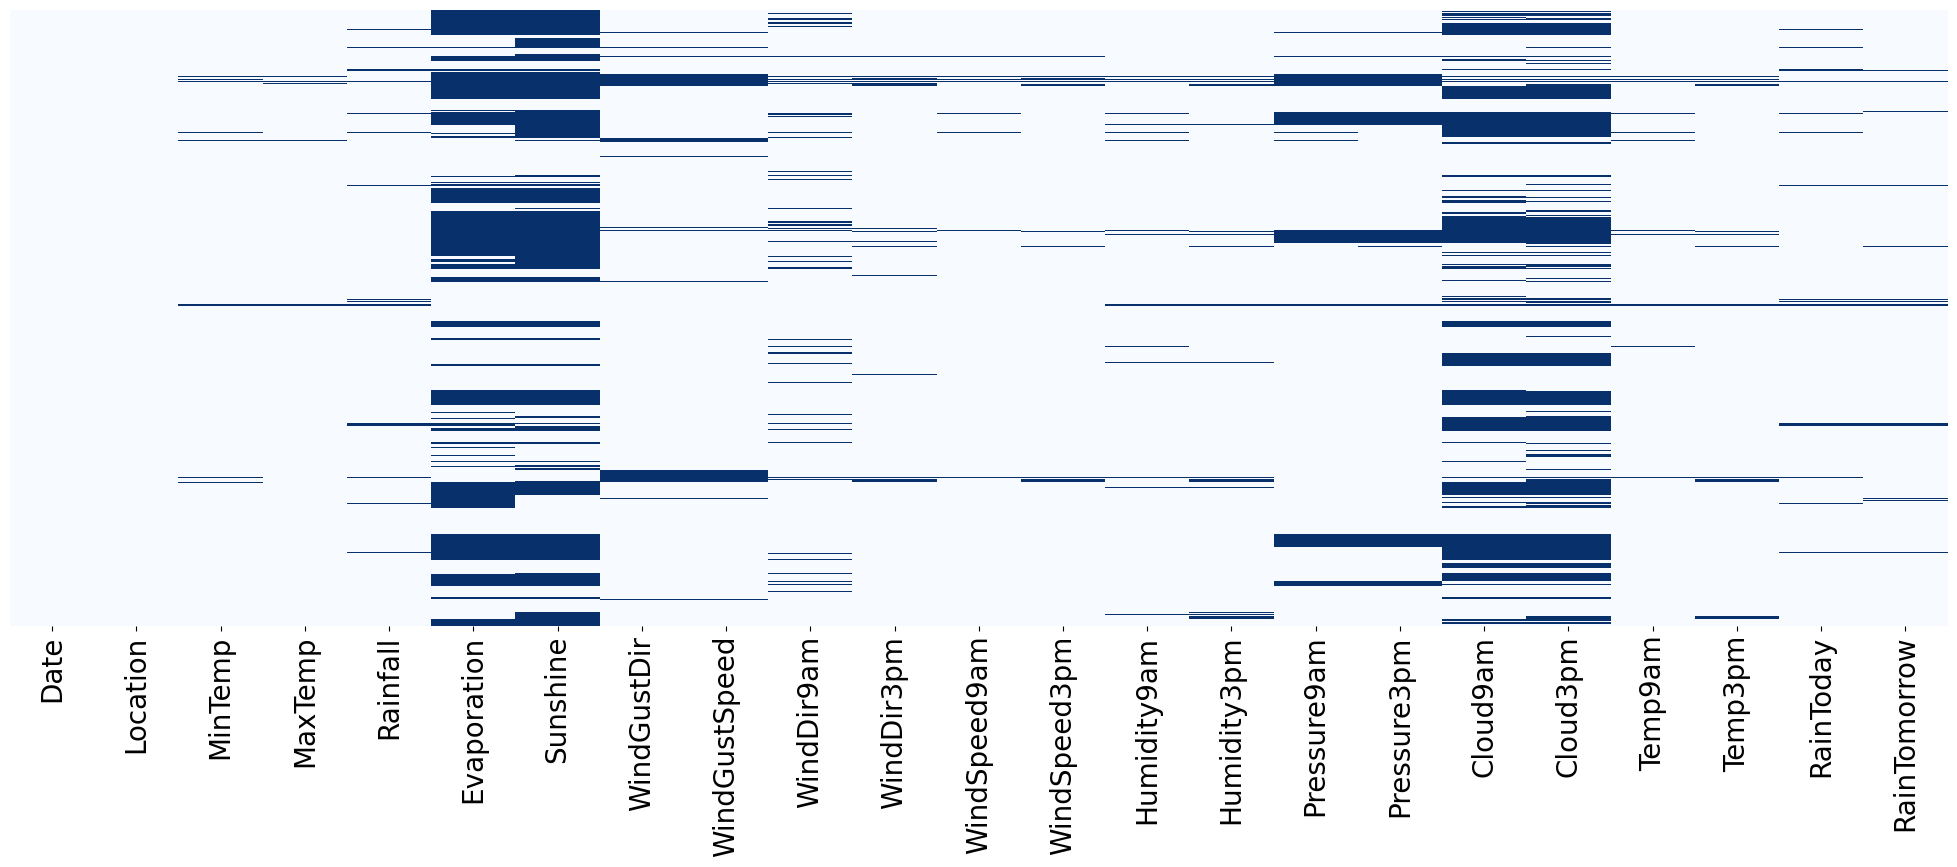

In [8]:
plt.figure(figsize = (25,8))
sns.heatmap(df.isnull(), cbar=False, cmap='Blues', yticklabels=False)
plt.xticks(fontsize = 20)
plt.ylabel(None)
plt.show()

In [40]:
missing(df)

,Sunshine,Evaporation,Cloud3pm,Cloud9am,Pressure9am,Pressure3pm,WindDir9am,WindGustDir,WindGustSpeed,Humidity3pm,...,Rainfall,RainToday,WindSpeed3pm,Humidity9am,Temp9am,WindSpeed9am,MinTemp,MaxTemp,Location,Date
Percent,48.01,43.17,40.81,38.42,10.36,10.33,7.26,7.1,7.06,3.1,...,2.24,2.24,2.11,1.82,1.21,1.21,1.02,0.87,0.0,0.0
Total,69835.00,62790.00,59358.00,55888.00,15065.00,15028.00,10566.00,10326.0,10263.00,4507.0,...,3261.00,3261.00,3062.00,2654.00,1767.00,1767.00,1485.00,1261.00,0.0,0.0
